# Importing required libraries

In [ ]:
import hashlib
import os
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib.gridspec import GridSpec
from sklearn.metrics import classification_report
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Dense,
    DepthwiseConv2D,
    Flatten,
    GlobalAveragePooling2D,
    Input,
    MaxPooling2D,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2026-01-02 18:02:37.459551: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767376957.641326      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767376957.694095      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767376958.143166      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767376958.143207      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767376958.143210      55 computation_placer.cc:177] computation placer alr

# Reading the data 

you can download the data from https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset and modify the path in the code

In [2]:
data_dir = "../input/rice-image-dataset/Rice_Image_Dataset"

In [3]:
data_dir = Path(data_dir)

images = []
labels = []

category_names = []
for subdir in data_dir.iterdir():
    if subdir.is_dir():
        category_names.append(subdir.name)
        for image_path in list(data_dir.glob(f"{subdir.name}/*")):
            images.append(str(image_path))
            labels.append(subdir.name)
print(category_names)
            

['Karacadag', 'Basmati', 'Jasmine', 'Arborio', 'Ipsala']


In [4]:
len(images),len(labels)

(75000, 75000)

In [5]:
df = pd.DataFrame({'image': images, 'label': labels})

In [6]:
df.head()

,image,label
0,../input/rice-image-dataset/Rice_Image_Dataset...,Karacadag
1,../input/rice-image-dataset/Rice_Image_Dataset...,Karacadag
2,../input/rice-image-dataset/Rice_Image_Dataset...,Karacadag
3,../input/rice-image-dataset/Rice_Image_Dataset...,Karacadag
4,../input/rice-image-dataset/Rice_Image_Dataset...,Karacadag


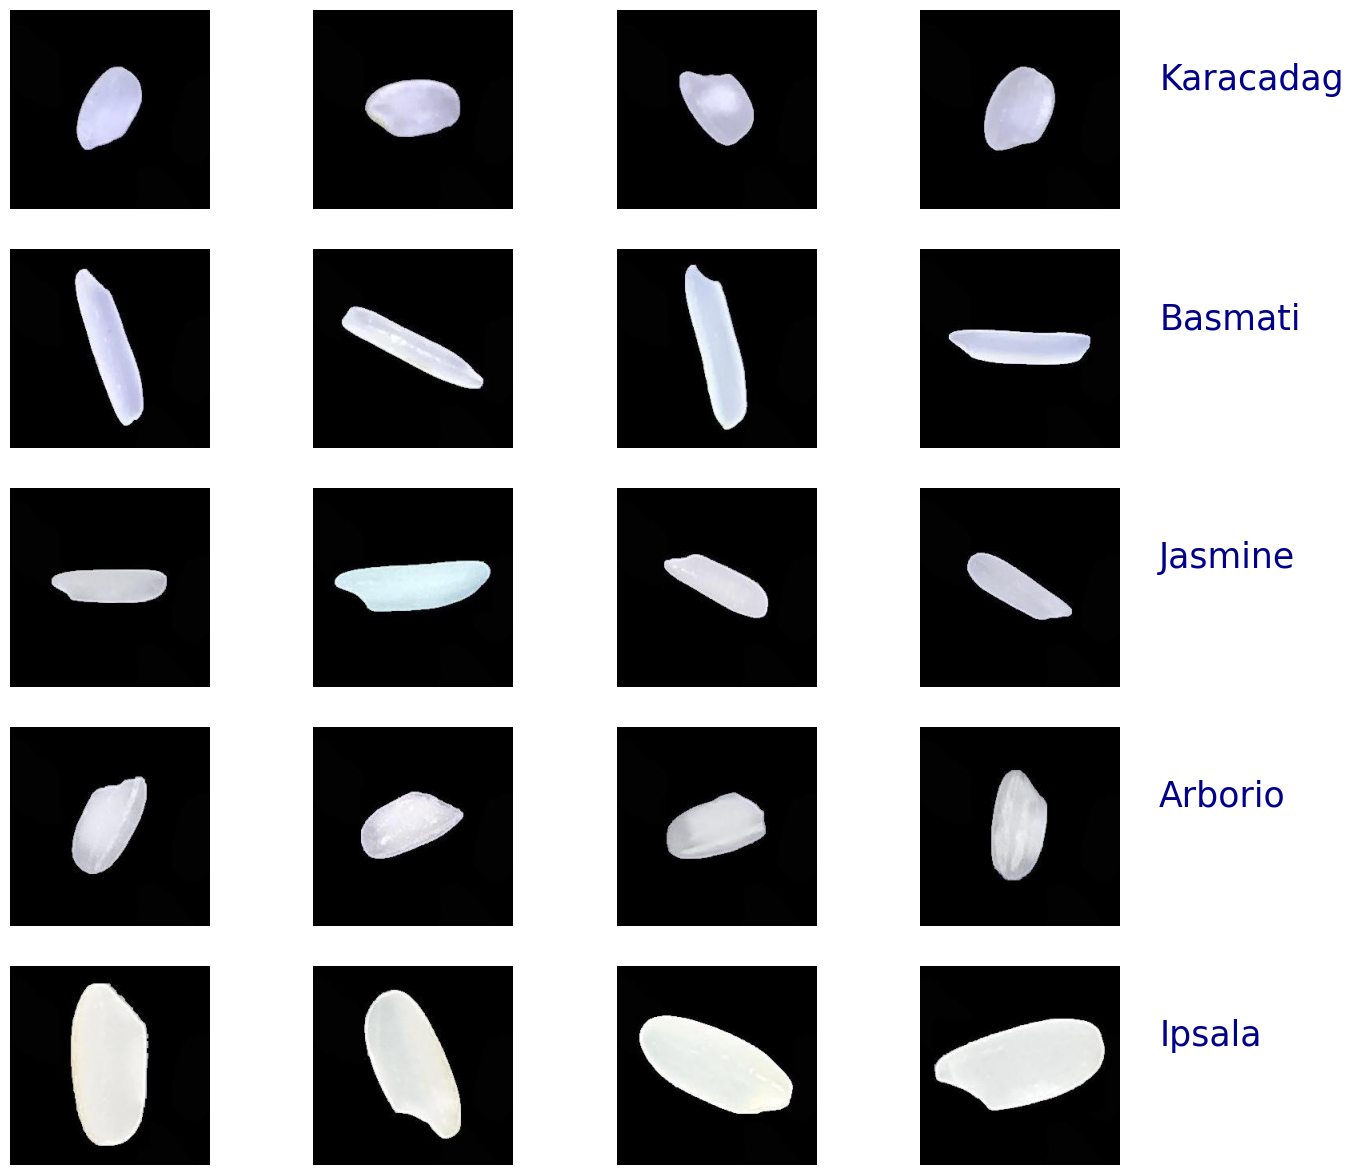

In [7]:

fig = plt.figure(figsize=(15, 15))
gs = GridSpec(5, 4, figure=fig)

for i, category in enumerate(df['label'].unique()):
    filepaths = df[df['label'] == category]['image'].values[:4]
    
    for j, filepath in enumerate(filepaths):
        ax = fig.add_subplot(gs[i, j])
        ax.imshow(plt.imread(filepath))
        ax.axis('off')
    
    ax.text(300, 100, category, fontsize=25, color='darkblue')

plt.show()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   75000 non-null  object
 1   label   75000 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


# Data Split

Spliting the data for training, testing and validation

In [9]:
from sklearn.model_selection import train_test_split

# First split: train+val vs test
df_train_val, df_test = train_test_split(
    df,
    test_size=0.1,
    stratify=df['label'],
    random_state=42
)

# Second split: train vs validation 
df_train, df_val = train_test_split(
    df_train_val,
    test_size=0.2,
    stratify=df_train_val['label'],
    random_state=42
)

print(len(df_train), len(df_val), len(df_test))

54000 13500 7500


In [10]:
classes = ['Karacadag','Ipsala','Arborio','Basmati','Jasmine']

In [11]:

datagen = ImageDataGenerator(rescale=1./255)

# Train generator
train_gen = datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='image',
    y_col='label',
    classes=classes,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Validation generator
val_gen = datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='image',
    y_col='label',
    classes=classes,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Test generator
test_gen = datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='image',
    y_col='label',
    classes=classes,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 54000 validated image filenames belonging to 5 classes.
Found 13500 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.


# Building the CNN Model

In [12]:
input_shape = (128, 128, 3)

In [13]:
model = Sequential()
model.add(Input(input_shape))
model.add(Conv2D(16, 3, strides=2, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(DepthwiseConv2D(3, padding="same", activation="relu"))
model.add(Conv2D(32, 1, activation="relu"))
model.add(BatchNormalization())
model.add(DepthwiseConv2D(3, strides=2, padding="same", activation="relu"))
model.add(Conv2D(64, 1, activation="relu"))
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation="relu"))
model.add(Dense(5, activation="softmax"))

I0000 00:00:1767377259.462100      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767377259.465971      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 64, 64, 16)     │           160 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_1              │ (None, 32, 32, 32)     │           320 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,517 (33.27 KB)

 Trainable params: 8,293 (32.39 KB)

 Non-trainable params: 224 (896.00 B)

In [15]:
model.compile(
    optimizer=Adam(learning_rate=3e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [16]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=2,
    min_lr=1e-6
)

In [17]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1767377263.835466     136 service.cc:152] XLA service 0x7c2040047f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767377263.835506     136 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1767377263.835513     136 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1767377264.419220     136 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1767377269.894803     136 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 259s 148ms/step - accuracy: 0.8081 - loss: 0.6194 - val_accuracy: 0.8416 - val_loss: 0.3877 - learning_rate: 3.0000e-04
Epoch 2/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 88s 52ms/step - accuracy: 0.9753 - loss: 0.0822 - val_accuracy: 0.7995 - val_loss: 0.6472 - learning_rate: 3.0000e-04
Epoch 3/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 89s 53ms/step - accuracy: 0.9850 - loss: 0.0478 - val_accuracy: 0.4982 - val_loss: 2.3639 - learning_rate: 3.0000e-04
Epoch 4/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 86s 51ms/step - accuracy: 0.9896 - loss: 0.0326 - val_accuracy: 0.9941 - val_loss: 0.0219 - learning_rate: 9.0000e-05
Epoch 5/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 88s 52ms/step - accuracy: 0.9917 - loss: 0.0284 - val_accuracy: 0.9934 - val_loss: 0.0195 - learning_rate: 9.0000e-05
Epoch 6/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 86s 51ms/step - accuracy: 0.9920 - loss: 0.0266 - val_accuracy: 0.9926 - val_loss: 0.0217 - learning_rate: 9.0000e-05
Epoch 7/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 87s 52m

In [18]:
loss, acc = model.evaluate(test_gen)
print("Test accuracy:", acc)

235/235 ━━━━━━━━━━━━━━━━━━━━ 42s 178ms/step - accuracy: 0.9956 - loss: 0.0117
Test accuracy: 0.9961333274841309


In [19]:
class_names = list(test_gen.class_indices.keys())
class_names

['Karacadag', 'Ipsala', 'Arborio', 'Basmati', 'Jasmine']

In [20]:

y_pred = model.predict(test_gen, verbose=1)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

print(
    classification_report(
        y_true,
        y_pred_labels,
        target_names=class_names
    )
)

235/235 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step
              precision    recall  f1-score   support

   Karacadag       1.00      0.99      1.00      1500
      Ipsala       1.00      1.00      1.00      1500
     Arborio       0.99      1.00      0.99      1500
     Basmati       1.00      0.99      1.00      1500
     Jasmine       0.99      1.00      1.00      1500

    accuracy                           1.00      7500
   macro avg       1.00      1.00      1.00      7500
weighted avg       1.00      1.00      1.00      7500



Validation to see train and testing was done correctly

In [22]:
test_gen.shuffle


False

In [23]:
len(test_gen.classes) == test_gen.samples

True

In [24]:


def hash_file(p):
    return hashlib.md5(open(p,'rb').read()).hexdigest()

train_hashes = set(df_train.image.apply(hash_file))
test_hashes  = set(df_test.image.apply(hash_file))

print(len(train_hashes & test_hashes))


43


only 43 images are matching

In [25]:
model.export("saved_model_fp32")

INFO:tensorflow:Assets written to: saved_model_fp32/assets


INFO:tensorflow:Assets written to: saved_model_fp32/assets


Saved artifact at 'saved_model_fp32'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  136481154826064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136481139280976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136481139280016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136481139281744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136481139278480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136481139279824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136481139278288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136481139281360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136481139278864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136481139283472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13648113928404

In [26]:
model.save("rice_classifier.keras")

# Building TFLite Model

In [27]:


tflite_model_path = "model_fp32.tflite"

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"Saved TFLite model at {tflite_model_path}")


INFO:tensorflow:Assets written to: /tmp/tmpnkatf1l5/assets


INFO:tensorflow:Assets written to: /tmp/tmpnkatf1l5/assets


Saved artifact at '/tmp/tmpnkatf1l5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  136481154826064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136481139280976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136481139280016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136481139281744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136481139278480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136481139279824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136481139278288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136481139281360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136481139278864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136481139283472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13648113928404

W0000 00:00:1767379339.440146      55 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1767379339.440182      55 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


Saved TFLite model at model_fp32.tflite


I0000 00:00:1767379339.455563      55 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled


In [28]:
size = os.path.getsize(tflite_model_path) / (1024*1024)
print(f"TFLite model size: {size:.2f} MB")

TFLite model size: 0.04 MB


In [29]:
interpreter = tf.lite.Interpreter(model_path="model_fp32.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

correct = 0
total = 0
batch = 0

for images, labels in test_gen:
    for image, label in zip(images, labels):
        img_input = np.expand_dims(image, axis=0).astype(np.float32)

        start_time = time.time()
        interpreter.set_tensor(input_details[0]['index'], img_input)
        interpreter.invoke()
        inference_time = time.time() - start_time

        output = interpreter.get_tensor(output_details[0]['index'])
        pred_class = np.argmax(output)
        true_class = np.argmax(label)

        correct += int(pred_class == true_class)
        total += 1

        if total % 750 == 0:
            print(f"Pred: {pred_class}, True: {true_class}, Inference time: {inference_time*1000:.2f} ms")

    batch += 1
    if total >= 7500:
        break

print(f"Final FP32 TFLite Accuracy on {total} images: {correct/total:.4f}")


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Pred: 3, True: 3, Inference time: 0.37 ms
Pred: 0, True: 0, Inference time: 0.34 ms
Pred: 3, True: 3, Inference time: 0.34 ms
Pred: 1, True: 1, Inference time: 0.37 ms
Pred: 0, True: 0, Inference time: 0.37 ms
Pred: 0, True: 0, Inference time: 0.47 ms
Pred: 3, True: 3, Inference time: 0.40 ms
Pred: 0, True: 0, Inference time: 0.34 ms
Pred: 2, True: 2, Inference time: 0.41 ms
Pred: 2, True: 2, Inference time: 0.34 ms
Final FP32 TFLite Accuracy on 7500 images: 0.9961


In [30]:
def representative_dataset():
    for i in range(200):
        images, _ = train_gen[i]
        yield [images]

# Building INT8 Quantized Model

In [31]:
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model_fp32")

converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.representative_dataset = representative_dataset

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model = converter.convert()

with open("rice_classifier_cnn_int8.tflite", "wb") as f:
    f.write(tflite_model)

W0000 00:00:1767379352.408615      55 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1767379352.408649      55 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


In [32]:
interpreter = tf.lite.Interpreter(model_path="rice_classifier_cnn_int8.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input dtype:", input_details[0]["dtype"])
print("Output dtype:", output_details[0]["dtype"])


Input dtype: <class 'numpy.uint8'>
Output dtype: <class 'numpy.uint8'>


# Trade-off Analysis

In [33]:
KERAS_MODEL_PATH = "/kaggle/working/rice_classifier.keras"
TFLITE_FP32_PATH = "/kaggle/working/model_fp32.tflite"
TFLITE_INT8_PATH = "/kaggle/working/rice_classifier_cnn_int8.tflite"


In [34]:
def model_size_mb(path):
    return os.path.getsize(path) / (1024 * 1024)


In [35]:
def load_interpreter(model_path):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    return interpreter


In [36]:
def keras_predict(model, image):
    image = np.expand_dims(image, axis=0)
    pred = model.predict(image, verbose=0)
    return np.argmax(pred[0])


In [37]:
def tflite_fp32_predict(interpreter, image):
    image = np.expand_dims(image, axis=0).astype(np.float32)

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    interpreter.set_tensor(input_details[0]["index"], image)
    interpreter.invoke()

    output = interpreter.get_tensor(output_details[0]["index"])
    return np.argmax(output[0])


In [38]:
def tflite_int8_predict(interpreter, image):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    input_scale, input_zero = input_details[0]["quantization"]
    output_scale, output_zero = output_details[0]["quantization"]

    image = np.expand_dims(image, axis=0)
    image_uint8 = np.clip(image / input_scale + input_zero, 0, 255).astype(np.uint8)

    interpreter.set_tensor(input_details[0]["index"], image_uint8)
    interpreter.invoke()

    output_q = interpreter.get_tensor(output_details[0]["index"])
    output = (output_q.astype(np.float32) - output_zero) * output_scale

    return np.argmax(output[0])


In [39]:
def evaluate_accuracy(val_generator, max_images, predict_fn):
    correct = 0
    total = 0

    for images, labels in val_generator:
        for img, lbl in zip(images, labels):
            true = np.argmax(lbl)
            pred = predict_fn(img)
            correct += (pred == true)
            total += 1

            if total >= max_images:
                return correct / total


In [40]:
def measure_latency(val_generator, predict_fn, runs=50):
    times = []

    images, _ = next(val_generator)

    for i in range(runs):
        start = time.time()
        predict_fn(images[i % len(images)])
        times.append((time.time() - start) * 1000)

    return np.mean(times)


In [41]:
keras_model = tf.keras.models.load_model(KERAS_MODEL_PATH)

tflite_fp32 = load_interpreter(TFLITE_FP32_PATH)
tflite_int8 = load_interpreter(TFLITE_INT8_PATH)

MAX_IMAGES = 300

acc_keras = evaluate_accuracy(
    val_gen,
    MAX_IMAGES,
    lambda img: keras_predict(keras_model, img)
)

acc_tflite_fp32 = evaluate_accuracy(
    val_gen,
    MAX_IMAGES,
    lambda img: tflite_fp32_predict(tflite_fp32, img)
)

acc_tflite_int8 = evaluate_accuracy(
    val_gen,
    MAX_IMAGES,
    lambda img: tflite_int8_predict(tflite_int8, img)
)

lat_keras = measure_latency(
    val_gen,
    lambda img: keras_predict(keras_model, img)
)

lat_tflite_fp32 = measure_latency(
    val_gen,
    lambda img: tflite_fp32_predict(tflite_fp32, img)
)

lat_tflite_int8 = measure_latency(
    val_gen,
    lambda img: tflite_int8_predict(tflite_int8, img)
)


In [42]:
print("MODEL COMPARISON\n")
print(f"{'Model':<20} {'Size(MB)':<10} {'Accuracy':<10} {'Latency(ms)':<12}")
print("-" * 55)

print(f"{'Keras FP32':<20} {model_size_mb(KERAS_MODEL_PATH):<10.2f} {acc_keras:<10.3f} {lat_keras:<12.2f}")
print(f"{'TFLite FP32':<20} {model_size_mb(TFLITE_FP32_PATH):<10.2f} {acc_tflite_fp32:<10.3f} {lat_tflite_fp32:<12.2f}")
print(f"{'TFLite INT8':<20} {model_size_mb(TFLITE_INT8_PATH):<10.2f} {acc_tflite_int8:<10.3f} {lat_tflite_int8:<12.2f}")


MODEL COMPARISON

Model                Size(MB)   Accuracy   Latency(ms) 
-------------------------------------------------------
Keras FP32           0.16       1.000      60.00       
TFLite FP32          0.04       1.000      0.47        
TFLite INT8          0.02       0.390      1.30        


The TFLite FP32 model has better accuracy and performance than other models